---

<div align="center" style="font-size:24pt">BE 537 Assignment 2 Base Component (2022)</div>

---
# Introduction

We will be implementing the non-symmetric version of the *Log-Domain Demons* algorithm by Vercauteren et al. (2008). Before the advent of deep learning image registration, the approach was arguably the most widely used deformable image registration approach because of its speed and ability to produce diffeomorphic transformations. You may find it easiest to follow the description of the algorithm in Section 3.2.3 (Algorithm 4) in the [Non-Parametric Volumetric Registration (NVR) book chapter](https://canvas.upenn.edu/courses/1677962/files/112454329). 

In this assignment, most of the code is already provided. There are six tasks in the base component of the assignment that require answering mathematical questions or coding, indicated in bold below. The total number of points for these seven tasks is 70.

# Preliminaries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, 'drive/MyDrive/be537/assignments/assignment2/package/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load required packages

I have provided an implementation of the functions from the first assignment in a Python module `be537hw1`. You will use some of these functions again in this assignment. There are also a few helpful functions in module `be537hw2` that we will use. To see the listing of functions available in `be537hw1` and `be537hw2`, type

```python
help('be537hw1')
help('be537hw2')
```

The cell below loads the required packages and sets the data path. **Update the data path for your environment**.

In [2]:
# Import required libraries
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as tfun

# Import the functions from the first assignment
from be537hw1 import *
from be537hw2 import *

# Configure matplotlib options
import matplotlib
%matplotlib inline

# Path to the data for this experiment
data_path='drive/MyDrive/be537/assignments/assignment2/package/data/'
print(os.path.abspath(data_path))

/content/drive/MyDrive/be537/assignments/assignment2/package/data


## Set up GPU capabilities

The cell below sets up a CUDA device to use with torch, if available to you. If you want to use the CPU even if a GPU is present, set `force_cpu` to be `True`. 

You can create tensors that reside on the GPU with the command `T = torch.Tensor(..., device=cuda)` and copy existing tensors to the GPU with the command `T.to(cuda)`. If you do not have a GPU, these commands will still work. 

- You do not need a GPU for the base component of the assignment, but I recommend using it for the extensions


In [3]:
# Set up CUDA if available
force_cpu = False
if torch.cuda.is_available() and not force_cpu:
  cuda = torch.device('cuda', 0)
  print("Using CUDA device %d named '%s' with %6.2f Gb total memory" % 
        (cuda.index, torch.cuda.get_device_name(cuda.index),
         torch.cuda.get_device_properties(cuda.index).total_memory / 2.0**30))
else:
  cuda = torch.device('cpu')
  print("Using CPU")

Using CUDA device 0 named 'Tesla T4' with  14.76 Gb total memory


## New Visualization Code
Module `be537hw2` contains two new functions `my_view_multi` and `my_view_ovl` for visualizing multiple images at once. They will be useful for viewing registration results. The code below loads a pair of images from the `testing` directory. The first is the atlas image with ID *1000*, which we will be treating as the *fixed* image. The second is the atlas with ID *1001* that has been aligned to the fixed image using affine registration. We will be treating it as the *moving* image for our deformable registration experiments. 

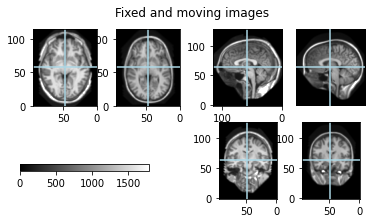

In [4]:
# Read the fixed image
I_fix, hdr_fix = my_read_pytorch_image_from_nifti(
    os.path.join(data_path,'testing/atlas_2mm_1000_3.nii.gz'), 
    dtype=torch.float32, device=cuda)

# Read the moving image
I_mov, hdr_mov = my_read_pytorch_image_from_nifti(
    os.path.join(data_path,'testing/reslice_affine_fx_1000_mv_1001.nii.gz'), 
    dtype=torch.float32, device=cuda)

# View the fixed and moving images side by side
my_view_multi([I_fix, I_mov], hdr_fix, cmap='gray', title='Fixed and moving images')

And here the two images are displayed as overlays

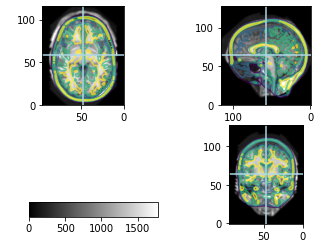

In [5]:
my_view_overlay(I_fix, I_mov, hdr_fix, cmap='gray')

## Working with deformable transformations
Before getting started, it is important to understand how spatial transformations are represented in Pytorch. 

### Order of dimensions
Recall that 3D images are represented in Pytorch as 5D-tensors of dimensions $[N,C,D,H,W]$ where $N$ is the mini-batch size (1 for now), $C$ is the number of channels (1 for grayscale, 3 for an RGB image), and $D, H, W$ are the dimensions of the 3D image.

Spatial transformations are 3D images that contain a coordinate $\phi({\boldsymbol x})$ at every voxel ${\boldsymbol x}$. They can be represented as 3D images with $C=3$ channels. However, recall from Assignment 1 that the function `grid_sample` expects spatial transformations to be represented as 5D tensors with dimensions $[N,D,H,W,3]$. Notice that instead of storing the spatial coordinates in the second dimension, the coordinates are stored in the last dimension. In this assignment, we will represent spatial transformations consistent with `grid_sample`.

- You can use function `torch.permute` to go back and forth between $[N,3,D,H,W]$ and $[N,D,H,W,3]$ representations of a spatial transformation

### Spatial Transformation vs. Displacement Field
Recall the distinction between a *spatial transformation* and a *displacement field.* A transformation $\phi$ assigns to each point $\boldsymbol{x}$ in the image domain another point, $\phi(\boldsymbol{x})$. A displacement field $\boldsymbol{u}$ assigns to each point $\boldsymbol{x}$ a displacement vector $\boldsymbol{u}(\boldsymbol{x})$. The two are related simply as $\phi(\boldsymbol{x})=\boldsymbol{x}+\boldsymbol{u}(\boldsymbol{x})$. Because of this simple relationship, we can think of a displacement field as just another way to represent a spatial transformation. It turns out that in practice representing spatial transformations as displacement fields is easier, particularly when it comes to applying composition operations to spatial transformations. In this assignment, we will represent spatial transformations as displacement fields.

### Displacement Field IO
Module `be537hw2` contains the function `my_read_pytorch_warp_from_nifti` that can read a displacement field output by registration tools [ANTs](http://stnava.github.io/ANTs/) and [Greedy](https://github.com/pyushkevich/greedy) and return a PyTorch tensor compatible with `grid_sample`.

The next code snippet loads a displacement field (or "warp") computed using [Greedy](https://github.com/pyushkevich/greedy) between the fixed and moving images and applies it to the moving image. The transformed (or "resliced") moving image is displayed as an overlay on top of the fixed image. Observe that the contours from the resliced moving image match the structures in the fixed image better than in the previous plot.

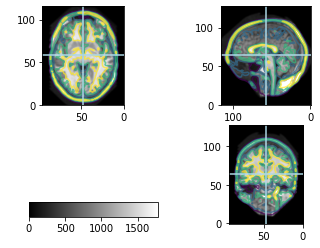

In [6]:
# Read the spatial transformation (warp for short)
I_warp, hdr_warp = my_read_pytorch_warp_from_nifti(
    os.path.join(data_path,'testing/warp_fx_1000_mv_1001.nii.gz'), 
    dtype=torch.float32, device=cuda)

# Create a coordinate grid for using with grid_sample
grid = my_create_pytorch_grid(I_fix.shape).to(cuda)

# Reslice the moving image using the warp
I_res = tfun.grid_sample(I_mov, grid + I_warp, align_corners=False)

# View the fixed and resliced images
my_view_overlay(I_fix, I_res, hdr_fix, cmap='gray')

# Implement Diffeomorphic Demons Registration in PyTorch

In this section, we will implement the diffeomorphic demons image registration algorithm and test it on the imaging data provided. Most code is provided. The portions where you have to write code or answer questions are labeled **TASK 1**, etc.

## Building blocks of the algorithm
Implementing the *Log-Domain Demons* algorithm by Vercauteren et al. (2008) will require the following components:

- **Scaling and squaring**, a technique that converts a smooth and bounded velocity field into a diffeomorphic transformation

- **Image gradient computation**, needed to compute optical flow between fixed and moving images

- **Gaussian smoothing**, used to regularize velocity fields and displacement fields

- **Optical flow computation**, 

## Scaling and squaring
In this part of the assignment, you will implement the scaling and squaring operation. The scaling and squaring algorithm is described in Section 2.1.4 of the NVR chapter. We also discuss it in class on the first day of the deformable registration lecture. Scaling and squaring takes as input a vector field called a **stationary velocity field (SVF)** and generates a spatial transformation that is diffeomorphic. 

### Theory: Scaling and Squaring using Displacement Fields

The scaling and squaring algorithm is described in Section 2.1.4 of the NVR book chapter in terms of compositions of spatial transformations $\psi_k$. Since we will be working with displacement fields, we need to rewrite the algorithm in terms of displacement fields. 

In a Markdown cell in your notebook, prove the following:

-   If $\psi_1$ and $\psi_2$ are transformations with corresponding displacement fields $\boldsymbol{v}_1$ and $\boldsymbol{v}_2$, then the displacement field $\boldsymbol{w}$ corresponding to the transformation $\psi_1\circ\psi_2$ (the composition of $\psi_1$ and $\psi_2$) is given by $$\boldsymbol{w}(\boldsymbol{x})=\boldsymbol{v}_2(\boldsymbol{x})+\boldsymbol{v}_1(\boldsymbol{x}+\boldsymbol{v}_2(\boldsymbol{x}))$$
-   Next, rewrite the scaling and squaring algorithm (at the end of section 2.1.4 of the NVR chapter) using displacement fields $\boldsymbol{v}$ instead of spatial transformations $\psi$.

**TASK 1a (5 pts): Your proof goes here**

$\psi_{1}(x) = x + v_{1}(x) $

$\psi_{2}(x) = x + v_{2}(x) $

Let, 

$\psi_{3}(x) = \psi_{1}(x) \circ \psi_{2}(x) = \psi_{1}(\psi_{2}(x)) $

$ ⇒ \psi_{3}(x) = \psi_{1}(x + v_{2}(x)) $

$ \therefore \psi_{3}(x) = x + v_{2}(x) + v_{1}(x + v_{2}(x))$

The displacement field of $\psi_{3}(x)$ is $\psi_{3}(x) - x $

$\therefore w(x) =  v_{2}(x) + v_{1}(x + v_{2}(x))$


**TASK 1b (5 pts): Your algorithm goes here**

Let, $u(x)$ be a stationary velocity field.

With $n$ iteratons,

$ \psi_{0}(x) = x + \frac{1}{2^n}u(x)$

$v_0(x) + x = x + \frac{1}{2^n}u(x)$

So initialization:

$ v_{0}(x) = \frac{1}{2^n}u(x)$

The algorithm for k-th iteration:

$ v_{k} = v_{k-1}(x) + v_{k-1}(x + v_{k-1}(x)) $ for $k = 1, ..., K$

### Implementation of Scaling and Squaring
**TASK 2 (10 pts): Complete the code for a function that performs scaling and squaring.**

Hints:
- The only PyTorch functions needed to implement this function are `grid_sample` and `permute`.
- When calling `grid_sample`, the first input will need to be of shape `[1,3,D,H,W]` and the output will be of shape `[1,3,D,H,W]`. Since `grid_sample` expects inputs to have shape `[1,D,H,W,3]`, you will need to use `permute` twice inside of this function.


In [7]:
def my_scaling_and_squaring(u, grid, n = 6):
    """
    Apply scaling and squaring to a displacement field
    
    The input and output to this method are displacement fields, v and u, 
    respectively. If u is sufficiently smooth and bounded, theoretically, 
    the deformation field $\phi(x) = x + u(x)$ will be diffeomorphic
    
    :param u: Input stationary velocity field, PyTorch tensor of shape [1,D,H,W,3]
    :param grid: Sampling grid of size [1,D,H,W,3] (created by my_create_pytorch_grid)    
    :param n: Number of iterations of scaling and squaring (default: 6)
    
    :returns: Output displacement field, v, PyTorch tensor of shape [1,D,H,W,3]
    """    
    v0 = u*((0.5)**n) # initialize
    vi = torch.permute(v0, (0,4,1,2,3))
    
    for _ in range(n):
        curr_x = grid + torch.permute(vi, (0,2,3,4,1))
        
        # recursion
        vi = vi + tfun.grid_sample(vi, curr_x, align_corners=False)
    
    v = torch.permute(vi, (0,2,3,4,1))       
     
    return v

### Test Scaling and Squaring

To confirm that your code is working correctly, we perform the following test:

1. Load a sample stationary velocity field `I_svf` from `testing/svf_fx_1000_mv_1001.nii.gz`
2. Apply scaling and squaring to `I_svf` and use the result to transform the moving image
3. Compare the result to the moving image transformed using `I_warp` above

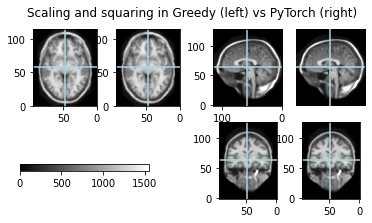

In [8]:
# Load the root warp
I_svf, hdr_svf = my_read_pytorch_warp_from_nifti(os.path.join(data_path,'testing/svf_fx_1000_mv_1001.nii.gz'),
                                                 dtype=torch.float32, device=cuda)

# Apply scaling and squaring to the SVF
I_warp_ss = my_scaling_and_squaring(I_svf, grid, 6)

# Sample the moving image using this transformation
I_res_ss = tfun.grid_sample(I_mov, grid + I_warp_ss, align_corners=False)

# Compare the two images
my_view_multi([I_res, I_res_ss], hdr_fix, cmap='gray', 
             title='Scaling and squaring in Greedy (left) vs PyTorch (right)')

Here is the quantitative comparison of the two images (you should expect the values to be ~$0.1$ for mean absolute difference and ~$4.0$ for max absolute difference

In [9]:
print('Difference between I_res and I_res_ss')
print('  Mean absolute difference: ' , torch.mean(torch.abs(I_res-I_res_ss)))
print('  Maximum absolute difference: ', torch.max(torch.abs(I_res - I_res_ss)))

Difference between I_res and I_res_ss
  Mean absolute difference:  tensor(0.1036, device='cuda:0')
  Maximum absolute difference:  tensor(4.2585, device='cuda:0')


## Gradient computation

We will need to approximate the gradient of the moving image during each step of the deformable registration algorithm. The gradient of an image can be represented as a multi-component image $\nabla I (\boldsymbol{x}) : \mathbb{R}^3 \rightarrow \mathbb{R}^3$. At each voxel, this image contains the three partial derivatives of $I$ with respect to the coordinates $x_1$, $x_2$, $x_3$: 

$$ \nabla I (\boldsymbol{x}) = \left[ \frac{\partial I}{\partial x_1}, \frac{\partial I}{\partial x_2}, \frac{\partial I}{\partial x_3} \right]^T $$

It turns out that the images $\frac{\partial I}{\partial x_1}$, $\frac{\partial I}{\partial x_2}$, and $\frac{\partial I}{\partial x_3}$ can each be approximated as discrete convolutions of the image $I$ with simple kernels consisting of three elements. 

**TASK 3 (10 pts):  Your derivation of the convolution kernels for image gradient computation goes here**

$$ I(\boldsymbol{y}) \simeq I(\boldsymbol{x}) + \sum_{i=1}^{3} \frac{\partial I}{\partial x_i}(\boldsymbol{x}) \cdot (y_i - x_i)
 + \sum_{i=1}^{3}\sum_{j=1}^{3} \frac{\partial^2 I}{\partial x_i \partial x_j}(\boldsymbol{x}) \cdot \frac{(y_i - x_i)(y_j - x_j)}{2}$$

For $\frac{\partial I}{\partial x_1}$, since we are interested in the $i=1$ term of $\boldsymbol{x}$:

$I(\boldsymbol{x} + \delta_1 \boldsymbol{e}_1) =I(\boldsymbol{x}) + \frac{\partial I}{\partial x_1}(\boldsymbol{x})( x_{1} +\delta_1 - x_{1}) +  \frac{\partial^2 I}{\partial x_1^2}(\boldsymbol{x})\frac{( x_{1} +\delta_1 - x_{1})(x_{1} +\delta_1 - x_{1})}{2}$

$\therefore I(\boldsymbol{x} + \delta_1 \boldsymbol{e}_1) =I(\boldsymbol{x}) + \delta_1\frac{\partial I}{\partial x_1}(\boldsymbol{x}) +  \frac{\delta_1^2}{2}\frac{\partial^2 I}{\partial x_1^2}(\boldsymbol{x})$

And,


$I(\boldsymbol{x} - \delta_1 \boldsymbol{e}_1) =I(\boldsymbol{x}) + \frac{\partial I}{\partial x_1}(\boldsymbol{x})( x_{1} -\delta_1 - x_{1}) +  \frac{\partial^2 I}{\partial x_1^2}(\boldsymbol{x})\frac{( x_{1} -\delta_1 - x_{1})(x_{1} -\delta_1 - x_{1})}{2}$

$\therefore I(\boldsymbol{x} - \delta_1 \boldsymbol{e}_1) =I(\boldsymbol{x}) - \delta_1\frac{\partial I}{\partial x_1}(\boldsymbol{x}) +  \frac{\delta_1^2}{2}\frac{\partial^2 I}{\partial x_1^2}(\boldsymbol{x})$

So,

$I(\boldsymbol{x} + \delta_1 \boldsymbol{e}_1)  - I(\boldsymbol{x} - \delta_1 \boldsymbol{e}_1) =  I(\boldsymbol{x}) + \delta_1\frac{\partial I}{\partial x_1}(\boldsymbol{x}) +  \frac{\delta_1^2}{2}\frac{\partial^2 I}{\partial x_1^2}(\boldsymbol{x}) - I(\boldsymbol{x}) + \delta_1\frac{\partial I}{\partial x_1}(\boldsymbol{x}) -  \frac{\delta_1^2}{2}\frac{\partial^2 I}{\partial x_1^2}(\boldsymbol{x})$

$I(\boldsymbol{x} + \delta_1 \boldsymbol{e}_1)  - I(\boldsymbol{x} - \delta_1 \boldsymbol{e}_1) =  2\delta_1\frac{\partial I}{\partial x_1}(\boldsymbol{x})$

$\therefore  \frac{\partial I}{\partial x_1}(\boldsymbol{x}) =  - \frac{1}{2\delta_1}I(\boldsymbol{x}- \delta_1 \boldsymbol{e}_1) + \frac{1}{2\delta_1}I(\boldsymbol{x} + \delta_1 \boldsymbol{e}_1)  $

If we consider $d_1 = -\frac{1}{2\delta_1}$ and $d_2 = \frac{1}{2\delta_1}$, this relationship between the derivative of $I(\boldsymbol{x})$ at each pixel and the value of $I(\boldsymbol{x})$ at adjacent pixels can also be expressed as a discrete convolution between $I(\boldsymbol{x})$ and a size (3,1,1) kernel $[[[d_1]],[[0]],[[d_2]]]$.

Similarly for $\frac{\partial I}{\partial x_2}$, we have:

$\therefore  \frac{\partial I}{\partial x_2}(\boldsymbol{x}) = - \frac{1}{2\delta_2}I(\boldsymbol{x}- \delta_2 \boldsymbol{e}_2)   + \frac{1}{2\delta_2}I(\boldsymbol{x} + \delta_2 \boldsymbol{e}_2)$

$h_1 = -\frac{1}{2\delta_2}$ and $h_2 = \frac{1}{2\delta_2}$

The relationship between the derivative of $I(\boldsymbol{x})$ at each pixel and the value of $I(\boldsymbol{x})$ at adjacent pixels can also be expressed as a discrete convolution between $I(\boldsymbol{x})$ and a size (1,3,1) kernel $[[[h_1]],[0],[[h_2]]]$

For $\frac{\partial I}{\partial x_3}$, we have:

$\therefore  \frac{\partial I}{\partial x_3}(\boldsymbol{x}) = - \frac{1}{2\delta_3}I(\boldsymbol{x}- \delta_3 \boldsymbol{e}_3)   + \frac{1}{2\delta_3}I(\boldsymbol{x} + \delta_3 \boldsymbol{e}_3)$

$w_1 = -\frac{1}{2\delta_3}$ and $w_2 = \frac{1}{2\delta_3}$

The relationship between the derivative of $I(\boldsymbol{x})$ at each pixel and the value of $I(\boldsymbol{x})$ at adjacent pixels can also be expressed as a discrete convolution between $I(\boldsymbol{x})$ and a size (1,1,3) kernel $[[[w_1, 0, w_2]]]$


### Implementation

**TASK 4 (10 pts):  Write a function with a signature below that computes the gradient of a 3D image**

Hints:
* The gradient computation can be accomplished using a single call to `torch.nn.functional.conv3d` with `I` as the first parameter and the second parameter a tensor of size $[3,1,3,3,3]$ that contains your three kernels.
* The spacings $\delta_1,\delta_2,\delta_3$ should be with respect to the PyTorch coordinate system, in which the image domain is the cube $[-1,1]\times[-1,1]\times[-1,1]$. So for an image of size $ N_1 \times N_2 \times N_3$, we will have $\delta_1 = \frac{2}{N_1}$, etc.


In [18]:
# Compute the gradient of a 3D image in PyTorch
def my_image_gradient(I):
    """
    Compute the gradient of an image using central difference approximation
    
    :param I: input image, represented as a [N,1,D,H,W] tensor
    :returns: gradient of the input image, represented as a [N,3,D,H,W] tensor
    """
    (N, C, D, H, W) = I.shape
    
    #-----------version 1-------------#
    
    # kernel_pd1 = torch.tensor([-0.25*D, 0, 0.25*D]).unsqueeze(-1).unsqueeze(-1) # (3,1,1)
    # kernel_pd2 = torch.tensor([-0.25*H, 0, 0.25*H]).unsqueeze((0)).unsqueeze(-1) # (1,3,1)
    # kernel_pd3 = torch.tensor([-0.25*W, 0, 0.25*W]).unsqueeze(0).unsqueeze(0) # (1,1,3)
    
    # I_grad1 = tfun.conv3d(I, kernel_pd1.unsqueeze(0).unsqueeze(0), padding="same")
    # I_grad2 = tfun.conv3d(I, kernel_pd2.unsqueeze(0).unsqueeze(0), padding="same")
    # I_grad3 = tfun.conv3d(I, kernel_pd3.unsqueeze(0).unsqueeze(0), padding="same")
    
    # I_grad = torch.cat((I_grad3, I_grad2, I_grad1), dim=1)    
    
    #-----------version 2-------------#
    
    k1 = torch.tensor([-0.25*D, 0, 0.25*D], device=cuda).reshape((3,1,1))
    k2 = torch.tensor([-0.25*H, 0, 0.25*H], device=cuda).reshape((1,3,1))
    k3 = torch.tensor([-0.25*W, 0, 0.25*W], device=cuda).reshape((1,1,3))
    
    k1 = tfun.pad(k1, (1, 1, 1, 1, 0, 0))
    k2 = tfun.pad(k2, (1, 1, 0, 0, 1, 1))
    k3 = tfun.pad(k3, (0, 0, 1, 1, 1, 1))
    
    kernel = torch.stack((k3, k2, k1)).unsqueeze(0).reshape((3,1,3,3,3))
    
    I_grad = tfun.conv3d(I, kernel, padding="same")
    
    return I_grad

### Check Gradient Computation

Plot the image gradient using the commands. The expected output is shown below:

<img src='files/gradient_example.png' alt='Gradient of the moving image' width=88%>


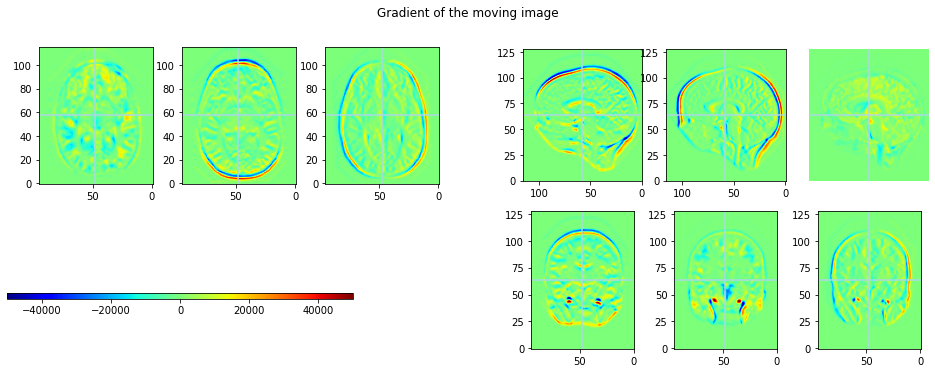

In [19]:
I_mov_grad = my_image_gradient(I_mov)
my_view_multi(I_mov_grad, hdr_mov, cmap='jet', crange=[-50000,50000], 
              transpose=True, title='Gradient of the moving image', figwidth=16);

Also plot the gradient magnitude image i.e. an image where at every voxel the intensity is equal to $|\nabla I|$. The gradient magnitude is large at edges in the image.

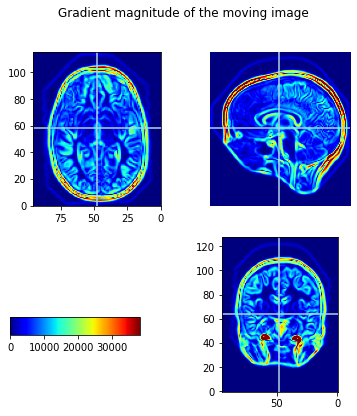

In [20]:
my_view_multi(torch.sqrt(I_mov_grad.square().sum(1)), hdr_mov, cmap='jet',
              title='Gradient magnitude of the moving image', figwidth=6)

## Gaussian Smoothing
Implementing Gaussian smoothing in Pytorch efficiently requires computing the fast Fourier transform (FFT) of the input image and the Gaussian kernel, multiplication in the frequency domain, and taking the inverse FFT. Getting this to work correctly is a little tricky, so the code for Gaussian smoothing is provided for you in functions `my_pytorch_gaussian_lpf` and `my_pytorch_gaussian_lpf_transform`.

In [21]:
# Function to generate FFT of a Gaussian kernel for use in PyTorch FFT
def my_gaussian_fft_kernel(I_ref, sigma):
    """
    Generate the FFT of a Gaussian kernel that can be used for FFT-based Gaussian smoothing 
    
    :param I_ref: 5D tensor that will be convolved with the kernel, used to infer the 
                  shape, data type and device for the output kernel
    :param sigma: standard deviation of the Gaussian kernel
    :param dtype: data type of the output tensor (default: torch.float32)
    :returns: 5D tensor that can be multiplied by the image RFFT for FFT-based smoothing
    """
    
    # Generate a Gaussian kernel, convert to PyTorch
    K = torch.tensor(my_gaussian_3d(sigma), 
                     dtype=I_ref.dtype, 
                     device=I_ref.device).unsqueeze(0).unsqueeze(0)
    
    # Normalize the kernel
    K = K / K.sum()
    
    # Pad the kernel so it is centered in an image of size I_ref.shape
    ab_pad = np.array(I_ref.shape[2:5]) - np.array(K.shape[2:5])
    a_pad = np.floor(ab_pad / 2)
    b_pad = ab_pad - a_pad
    pad_5d = tuple(np.flip(np.vstack((a_pad, b_pad)).T.flatten()).astype(int))+(0,0,0,0)
    K_pad = tfun.pad(K,pad_5d)
    
    # Return the real FFT of the kernel
    return torch.fft.rfftn(K_pad)
    

# Function to smooth a scalar image with a Gaussian using PyTorch FFT
def my_pytorch_gaussian_lpf(img, sigma=None, kernel=None):
    """
    Apply Gaussian smoothing to a 3D image represented as a PyTorch tensor
    
    You can pass in the sigma of the Gaussian or a 5D tensor representing the Gaussian
    kernel (generated using `my_gaussian_fft_kernel`). The latter is faster if you will
    be making repeated calls to this function.
    
    :param img: Input image, represented as a 5D tensor
    :param sigma: Standard deviation of the Gaussian kernel. If `kernel` parameter
        is not supplied, the kernel will be generated by calling `my_gaussian_fft_kernel`
    :param kernel: Gaussian kernel generated by `my_gaussian_fft_kernel`. 
    """
    
    # Either sigma or kernel must be provided
    assert sigma is not None or kernel is not None
    if kernel is None:
        kernel = my_gaussian_fft_kernel(img, sigma)
    
    # Create a Gaussian kernel
    img_fft = torch.fft.rfftn(img)
    return torch.fft.fftshift(torch.fft.irfftn(img_fft * kernel))


# Function to smooth a deformation field with a Gaussian
def my_pytorch_gaussian_lpf_transform(v, sigma=None, kernel=None):
    """
    Apply Gaussian smoothing to a transform represented as a PyTorch tensor
    
    You can pass in the sigma of the Gaussian or a 5D tensor representing the Gaussian
    kernel (generated using `my_gaussian_fft_kernel`). The latter is faster if you will
    be making repeated calls to this function.
    
    :param img: Input spatial transformation, represented as a [N,D,H,W,3] tensor
    :param sigma: Standard deviation of the Gaussian kernel. If `kernel` parameter
        is not supplied, the kernel will be generated by calling `my_gaussian_fft_kernel`
    :param kernel: Gaussian kernel generated by `my_gaussian_fft_kernel`. 
    """
    
    # Make sure the image is formatted as a transform
    assert v.shape[4]==3

    # Convert the transform into a multi-channel image of shape [1,3,D,H,W]
    v_chan = v.permute(0,4,1,2,3)
    
    # Either sigma or kernel must be provided
    assert sigma is not None or kernel is not None
    if kernel is None:
        kernel = my_gaussian_fft_kernel(v_chan, sigma)
    
    # Perform FFT convolution but only along image dimensions
    v_fft = torch.fft.rfftn(v_chan, dim=(-3,-2,-1))
    v_sm_chan = torch.fft.fftshift(
        torch.fft.irfftn(v_fft * kernel, dim=(-3,-2,-1)),
        dim=(-3,-2,-1))
    
    # Reorder dimensions again
    return v_sm_chan.permute(0,2,3,4,1)

Here is an example of the fixed image smoothed in Pytorch

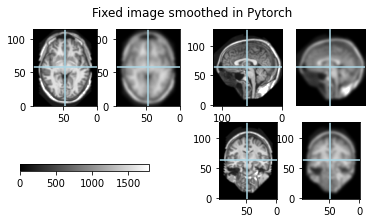

In [22]:
I_sm = my_pytorch_gaussian_lpf(I_fix, sigma=2.0)
my_view_multi([I_fix, I_sm], hdr_fix, title="Fixed image smoothed in Pytorch")

Here is an example of a deformation field smoothed in PyTorch

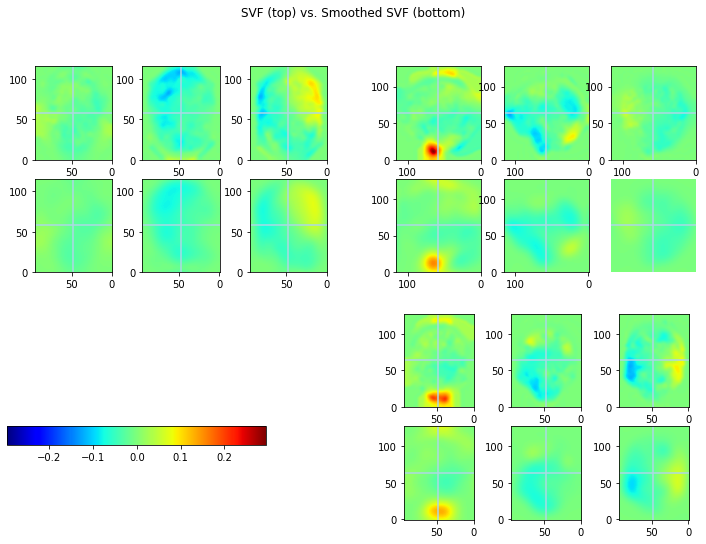

In [23]:
I_svf_sm = my_pytorch_gaussian_lpf_transform(I_svf, sigma=6.0)
my_view_multi(torch.cat((I_svf, I_svf_sm)), hdr_fix, is_warp=True, 
              transpose=True, cmap='jet', figwidth=12,
              title='SVF (top) vs. Smoothed SVF (bottom)')

## Optical flow computation

Optical flow will be discussed in the Deformable Registration lectures and is covered in Section 3.2.1 of the NVR Chapter. Recall that optical flow infers a velocity field from a pair of images. When these images are frames from a video sequence, the optical flow is an estimate of how fast objects or particles are moving in the video. When doing inter-subject registration, optical flow does not have the same clear physical meaning, but it can be thought of as an infinitecimal displacement that, when applied to the moving image, makes it a little more similar to the fixed image.

### Optical Flow Algorithms

Your task is to implement **two versions** of the optical flow approximation. 

One of them will be a simple approximation that is obtained if you differentiate the mean square difference metric  (MSD, also known as the sum of squared differences metric, or SSD) between $I(\boldsymbol{x})$ and $J^i(\boldsymbol{x}+\boldsymbol{v}(\boldsymbol{x}))$ with respect to $\boldsymbol{v}$. This approximation is referred to as `grad_msd` in the code below.

$${\boldsymbol{v}} = G_\sigma * (I - J^i) \nabla J^i $$

The other one can be one of the following:
* The original *Demons* approximation, given in Algorithm 3 (line 2b) of the NVR Chapter (Section 3.2.2). 
* The Lukas-Kanade algorithm (advanced)
* The Horn and Schunk algorithm (advanced)

### Implementation as a Python Class

When working with PyTorch to train neural networks we typically not only write Python functions, but also [Python **classes**](https://www.w3schools.com/python/python_classes.asp). A class is an object-oriented programming concept that allows data and functions to be abstracted away into a single entity. We will write a Python class to capture the logic of optical flow computation. The class will have a constructor (`__init__` function) that users call to configure the class (e.g., specify which optical flow method to use or how much smoothing to perform) and a method called `forward` that will perform the actual computation. Once we create an instance of this class, we can call `forward` multiple times with different image inputs.

**TASK 5 (20 pts): complete the class definition below by writing the code for the `forward` function**

Notes/Hints:
* You may find the function `torch.where` useful when implementing the conditional expression in the Demons formula
* Other functions that you will need here are `torch.square`, `torch.sum` and `torch.permute`
* For the `grad_msd` method, the magnitude of the velocity field retured by `forward` will be very large (on the order of $10^7$). This is okay because during registration we will normalize the velocity field so that the maximum displacement is on the order of one voxel.

In [27]:
class MyOpticalFlow:
    """A class that implements multiple optical flow algorithms"""
    
    def __init__(self, I, method='demons', sigma=2.0, demons_eps=0.001):
        """
        Initialize the optical flow computation
        
        :param I: Fixed image, represented as [N,1,D,H,W] tensor
        :param method: 
            String, specifies which method is used for the computation. Available
            options are 'demons' (default) and 'grad_msd'
        :param sigma: 
            Standard deviation for Gaussian smoothing in 'demons' and 'grad_msd' 
            methods (passed to `my_gaussian_fft_kernel`)
        :param demons_eps: 
            Only used if `method=='demons'`, sets the threshold on the denominator
            below which the flow is set to zero. See Algorithm 2 step 2b
        """
        self.method = method
        self.demons_eps = demons_eps
        self.kernel = my_gaussian_fft_kernel(I, sigma)
        
    def forward(self, I, J):
        """
        Compute optical flow for a given pair of fixed/moving images
                
        :param I: fixed image, represented as [N,1,D,H,W] tensor
        :param J: moving image, represented as [N,1,D,H,W] tensor
        :returns: optical flow velocity field, represented as a [N,D,H,W,3] tensor
        """
        if self.method=="grad_msd":
            vbg = (I-J) * my_image_gradient(J) # v before Gaussian
            
            vbg = torch.permute(vbg, (0,2,3,4,1))
            
            v = my_pytorch_gaussian_lpf_transform(vbg, kernel=self.kernel)
            
            return v
        
        elif self.method=="demons":
            numerator = (I-J) * my_image_gradient(J)
            denominator = torch.sum(torch.square(my_image_gradient(J)), dim=1)\
                + torch.sum(torch.square(J-I), dim=1)
            
            vbg = numerator/denominator
            vbg = torch.where(denominator>self.demons_eps, vbg, torch.zeros(vbg.shape, device=cuda))
            
            vbg = torch.permute(vbg, (0,2,3,4,1))
            
            v = my_pytorch_gaussian_lpf_transform(vbg, kernel=self.kernel).float()

            return v
                

### Check Optical Flow Computation

Visualize the optical flow fields that you obtain for the two methods using `my_view_multi` using code below. The output should look like `files/oflow_example.png`.

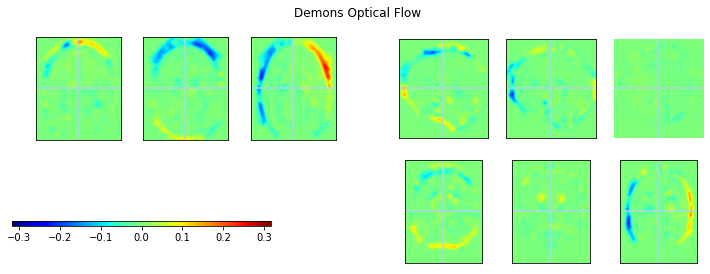

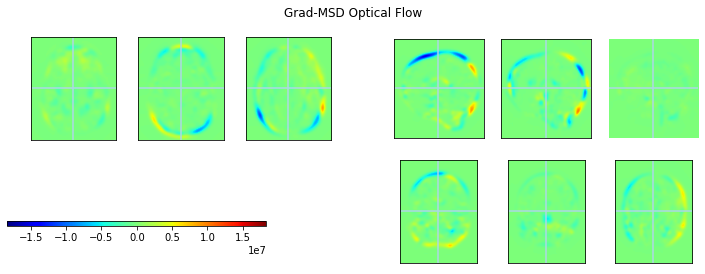

In [28]:
of_demons = MyOpticalFlow(I_fix, method='demons', sigma=2.0)
v_demons = of_demons.forward(I_fix, I_mov)

of_gradmsd = MyOpticalFlow(I_fix, method='grad_msd', sigma=2.0)
v_gradmsd = of_gradmsd.forward(I_fix, I_mov)

my_view_multi(v_demons, hdr_fix, cmap='jet', is_warp=True, transpose=True, 
              figwidth=12, axis_visible=False, title='Demons Optical Flow')

my_view_multi(v_gradmsd, hdr_fix, cmap='jet', is_warp=True, transpose=True, 
              figwidth=12, axis_visible=False, title='Grad-MSD Optical Flow')

## Log-Demons Algorithm

### Full-Resolution Method 
Finally, we are ready to implement the log-Demons algorithm, described in Algorithm 4 in the NVR chapter (Section 3.2.3). Again, we will implement it as a Python class `MyLogDemonsAlgorithm`

The method `__init__` will be responsible for storing the variables needed by the class (i.e., lines of code line `self.I = I`) and initializing the sampling grid and other objects that are repeatedly used during the algorithm.

The method `step` is the portion of the algorithm that is iterated. At every call to `step`, the spatial transformation $\phi^i$ and the stationary velocity field $u^i$ are updated. Note that consisently with how we implemented scaling and squaring, we use the displacement field $\boldsymbol{w}^i$ to represent the spatial transformation $\phi^i$ in our code. The two are related by $\phi^i(\boldsymbol{x}) = \boldsymbol{x} + \boldsymbol{w}^i(\boldsymbol{x})$.

The code for `MyLogDemonsAlgorithm` is provided to you, but it requires that gradient computation and scaling and squaring algorithms be implemented correctly.

In [30]:
class MyLogDemonsAlgorithm:
    """A class that performs log-Demons registration between two images"""
    
    def __init__(self, I, J, of, tau=0.5, eps_prime = 0.5):
        """
        Initialize the Log Demons algorithm
        
        :param I: Fixed image, represented as an [N,1,D,H,W] tensor
        :param J: Moving image, represented as an [N,1,D,H,W] tensor
        :param of: 
            Instance of class MyOpticalFlow used to perform optical flow computations
        :param tau: 
            Standard deviation for 'diffusion-like' regularization (Algorithm 4, Line 2c)
        :param eps_prime: 
            Normalization factor. The velocity field computed by optical flow will
            be scaled so that the longest velocity vector is equal to eps_prime 
            voxel widths. See second bullet point after Algorithm 3.
        """
        self.I = I
        self.J = J
        self.of = of
        self.kernel_tau = my_gaussian_fft_kernel(I, tau)
        self.eps_prime = eps_prime
        self.grid = my_create_pytorch_grid(I.shape, dtype=I.dtype, device=I.device)
        
    def step(self, w_i, u_i):
        """
        Execute one iteration of the Log Demons algorithm (Algorithm 4, Line 2)
        
        :param w_i: 
            Displacement field corresponding to the current estimate of the spatial
            transformation. Transformation $\phi_i$ is given by $\phi_i(x) = x + w_i(x)$.
            Represented as an [N,1,D,H,W] tensor.
        :param u_i: 
            Current estimate of the stationary velocity field $u_i$
            Represented as an [N,1,D,H,W] tensor.
        
        :returns:
            Tuple (Ji, rms, w_i1, u_i1) where
            
            - `Ji` is the moving image transformed by the spatial transformation $\phi_i$
            - `msd` is the mean square intensity difference between I and J^i
            - `w_i1` is the updated displacement field corresponding to $\phi_{i+1}$
            - `u_i1` is the updated stationary velocity field 
        """
            
        # Resample the moving image using current displacement field w_i
        J_i = tfun.grid_sample(self.J, self.grid + w_i, align_corners=False)

        # Compute the RMS metric between fixed image I and resampled moving image
        msd = torch.mean((self.I - J_i).square())

        # Compute the optical flow field between fixed image I and resampled moving image
        v_i = self.of.forward(self.I, J_i)

        # Scale the optical flow field so the longest vector does not exceed eps_prime 
        # (eps_prime is specified in voxel units, e.g., 0.5 voxel). 
        scale = self.eps_prime * np.min(2.0 / np.array(self.I.shape[2:5])) / torch.max(v_i)

        # Compute the updated SVF using the approximation of the Lie bracket term in Algorithm 4 line 2c
        u_i1 = my_pytorch_gaussian_lpf_transform(u_i + scale * v_i, kernel=self.kernel_tau)

        # Perform scaling and squaring to get a new transformation
        w_i1 = my_scaling_and_squaring(u_i1, self.grid)   

        # Return the updated w and u
        return J_i, msd, w_i1, u_i1

The code below should be used to test out your algorithm. It should produce output similar to what is shown below. The objective function should start at ~$96000$ and go down to ~$13000$. It might take a minute or two on a CPU to complete the 200 iterations.

<img src='files/reg_example.png' alt='Deformable registration result' width=88%>

In [31]:
log_demons = MyLogDemonsAlgorithm(I_fix, I_mov, of_gradmsd)
w_i = torch.zeros_like(I_fix).repeat((1,3,1,1,1)).permute(0,2,3,4,1)
u_i = w_i.clone()
for k in range(200):
    J_i, msd, w_i, u_i = log_demons.step(w_i, u_i)
    if k % 20 == 0:
        print('Iter %03d, MSD = %8.4f' % (k, msd))

Iter 000, MSD = 96846.3906
Iter 020, MSD = 52207.1992
Iter 040, MSD = 31559.2520
Iter 060, MSD = 22472.2324
Iter 080, MSD = 18530.4863
Iter 100, MSD = 15748.2754
Iter 120, MSD = 14349.0088
Iter 140, MSD = 14096.1768
Iter 160, MSD = 13312.1777
Iter 180, MSD = 13139.9023


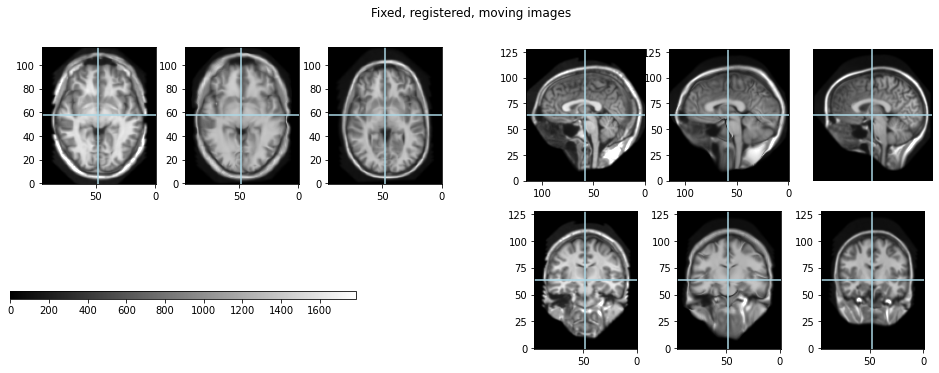

In [32]:
my_view_multi([I_fix, J_i, I_mov], hdr_fix, figwidth=16, 
              title='Fixed, registered, moving images')

### Multi-Resolution Log Demons
A major difference between the registration method above and tools like ANTS is that the latter use multi-resolution schemes for significantly faster optimization. For example, when registering images of 256x256x256 voxels, one would typically subsample to 64x64x64 and run registration at that resolution; then use the result to initialize registration at 128x128x128 resolution, and run that for some number of iterations and use the result to initialize full-resolution registration. This has a dramatic effect on registration quality. This section provides code for multi-resolution Log Demons registration. There is no code for you to write in this section.

First, we coded a function to downsample an image represented as a PyTorch tensor (`my_image_downsample` in `be537_hw2`).

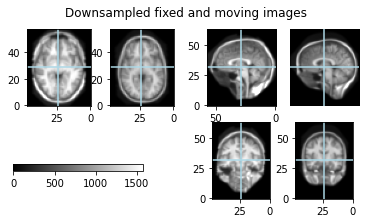

In [33]:
I_fix_ds = my_image_downsample(I_fix, 2.0)
I_mov_ds = my_image_downsample(I_mov, 2.0)
hdr_fix_ds = my_adjust_nifti_header_for_resample(hdr_fix, I_fix_ds.shape[2:5])
my_view_multi([I_fix_ds,I_mov_ds], hdr_fix_ds, 
              title="Downsampled fixed and moving images")

This function runs the log-Demons algorithm in a multi-resolution setting 

In [34]:
def my_log_demons_multires(I_fix, I_mov, iter_vec,
                           sigma=2.0, tau=0.5, eps_prime=0.5,
                           of_method='grad_msd', of_param = {}, 
                           silent=False):
    """
    Multi-resolution log Demons algorithm
    
    :param I_fix: Fixed image, represented as an [N,1,D,H,W] tensor
    :param I_mov: Moving image, represented as an [N,1,D,H,W] tensor
    :param iter_vec: 
        Number of iterations at each resolution level, e.g., [100,40] will
        do 100 iterations at 2x downsampling, 40 at full resolution
    :param sigma: See MyOpticalFlow
    :param tau: See MyLogDemonsAlgorithm
    :param eps_prime: See MyLogDemonsAlgorithm
    :param of_method: See MyOpticalFlow
    :param of_param: See MyOpticalFlow
    
    :returns:
        Tuple (I_res, rms, w, u) where

        - `I_res` is the moving image transformed by the spatial transformation $\phi$
        - `rms` is the root mean square intensity difference between I and I_res
        - `w` is the displacement field corresponding to $\phi$
        - `u` is the stationary velocity field corresponding to $\phi$
    """
    
    # Current u
    u = None
    
    # Iterate over resolution levels
    for level, n_iter in enumerate(iter_vec):
        
        # Downsample images by current factor
        factor = 2 ** (len(iter_vec) - level - 1)
        I_fix_ds = my_image_downsample(I_fix, factor)
        I_mov_ds = my_image_downsample(I_mov, factor)
        dim_ds = I_fix_ds.shape[2:5]
        
        # Resample u to the current iteration
        if u is not None:
            u = tfun.interpolate(u.permute(0,4,1,2,3), 
                                 tuple(dim_ds)).permute(0,2,3,4,1)
        else:
            u = torch.zeros_like(I_fix_ds).permute(0,2,3,4,1).repeat(1,1,1,1,3)
            
        # Create optical flow for this iteration
        of = MyOpticalFlow(I_fix_ds, sigma=sigma, method=of_method, **of_param)
        
        # Create the algorithm for this iteration
        log_demons = MyLogDemonsAlgorithm(I_fix_ds, I_mov_ds, of, tau=tau, 
                                          eps_prime=eps_prime)
            
        # Compute the displacement field w
        w = my_scaling_and_squaring(u, log_demons.grid)
        
        # Perform iterations
        for k in range(n_iter):
            I_res, msd, w, u = log_demons.step(w, u)
            if k % 10 == 0:
                if not silent:
                    print('Level %01d  Iter %03d  RMS %8.4f' % (level, k, msd.item()))
                      
    return I_res, msd, w, u

Run a multi-resolution registration. This registration should run faster than the one above and get the final RMS that is under $13,000$.

In [35]:
I_res, rms, phi, u = my_log_demons_multires(I_fix, I_mov, [80,80,40], of_method='grad_msd', sigma=1.0)

Level 0  Iter 000  RMS 38671.7969
Level 0  Iter 010  RMS 25605.3965
Level 0  Iter 020  RMS 23156.2090
Level 0  Iter 030  RMS 20229.6172
Level 0  Iter 040  RMS 19559.4141
Level 0  Iter 050  RMS 19037.0918
Level 0  Iter 060  RMS 18722.2539
Level 0  Iter 070  RMS 18559.9395
Level 1  Iter 000  RMS 36157.4648
Level 1  Iter 010  RMS 18300.3711
Level 1  Iter 020  RMS 13684.6992
Level 1  Iter 030  RMS 11146.5049
Level 1  Iter 040  RMS 10658.3428
Level 1  Iter 050  RMS 10496.4746
Level 1  Iter 060  RMS 10224.4717
Level 1  Iter 070  RMS 10139.5508
Level 2  Iter 000  RMS 16456.1543
Level 2  Iter 010  RMS 13733.7529
Level 2  Iter 020  RMS 13152.0605
Level 2  Iter 030  RMS 12773.3506


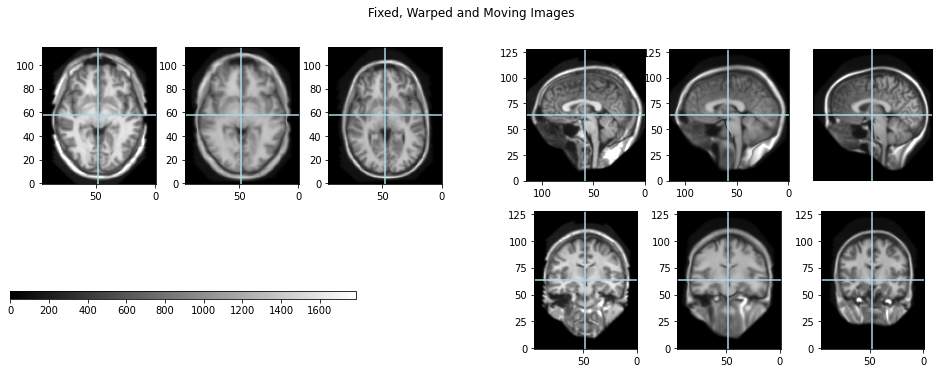

In [36]:
my_view_multi([I_fix,I_res,I_mov], hdr_fix, figwidth=16, title='Fixed, Warped and Moving Images')

Plot difference images before and after registration

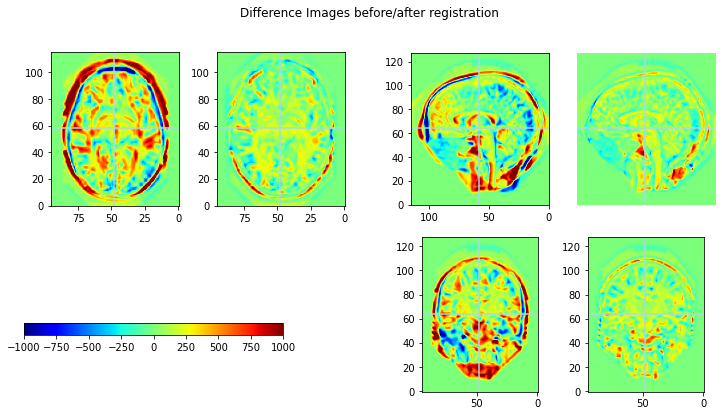

In [37]:
my_view_multi([I_fix-I_mov,I_fix-I_res], hdr_fix, cmap='jet', 
              crange=[-1000,1000], figwidth=12, 
              title='Difference Images before/after registration')

## Compare Affine and Deformable Registration for 10 Subject Pairs
In this final sub-task of the base component of the assignment, you will perform deformable registration between 10 randomly selected pairs of subjects in the dataset and evaluate how well these registrations align anatomical labels between images compared to affine registration. To make things simpler, we computed the affine transformations between all image pairs ahead of time. 

### Class to Load Registration Experiments

We also provide some helper code to save you some tedious work. The class `RegistrationExperiment` provided in the `be537hw2.py` lets you easily load and access all the data associated with each registration experiment. This class provides access to the following variables:

- `exp.I_fix`: Fixed image, represented as a PyTorch tensor
- `exp.S_fix`: Fixed image segmentation 
- `exp.I_mov`: Moving image
- `exp.S_mov`: Moving image segmentation 
- `exp.hdr_fix`: Fixed image header (for calling `my_view`)
- `exp.grid`: Fixed image coordinate grid (for calling `grid_sample`)
- `exp.A`, `exp.b`: Affine transform used to map the moving image into fixed image space.

The code below loads a registration experiment with subject `1002` as fixed and `1014` as moving.

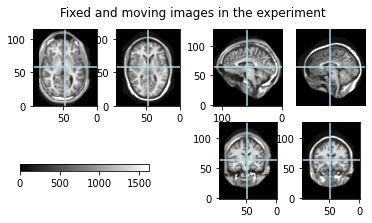

In [38]:
exp = RegistrationExperiment('1002','1014', data_path, dtype=torch.float32, device=cuda)
my_view_multi([exp.I_fix, exp.I_mov], exp.hdr_fix, 
              title='Fixed and moving images in the experiment')

### Function to apply affine and deformable transformations jointly

Another useful function we provided is `my_transform_affine_and_warp`. It allows you to apply the a combination of affine and deformable transformations to a moving image. If the deformable transformation is not specified (as in the line below), only the affine transformation is applied.

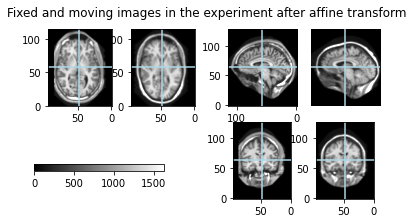

In [39]:
I_aff = my_transform_affine_and_warp(exp.I_mov, exp.grid, exp.A, exp.b)
my_view_multi([exp.I_fix, I_aff], exp.hdr_fix, 
              title='Fixed and moving images in the experiment after affine transform')

Now that we have the fixed image `exp.I_fix` and the affine-transformed moving image `I_aff`, we can apply your log-Demons algorithm to perform deformable registration. 

In [40]:
_, _, w_opt, _ = my_log_demons_multires(exp.I_fix, I_aff, [80,80,40], 
                                        of_method='grad_msd', sigma=1.0, 
                                        silent=True)

To apply the combination of deformable and affine transformations to the moving image, we use the command below. This helps avoid double interpolation and associated aliasing, that would happen if we first applied the affine transform and then separately applied the deformable transformation

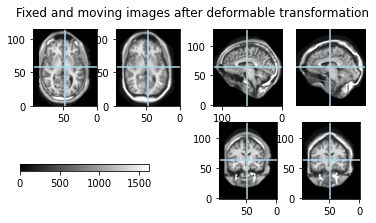

In [41]:
I_def = my_transform_affine_and_warp(exp.I_mov, exp.grid, exp.A, exp.b, w_opt)
my_view_multi([exp.I_fix, I_def], exp.hdr_fix, 
              title='Fixed and moving images after deformable transformation')

### Applying transformations to segmentation images

In order to apply your affine and deformable transformations to the anatomical segmentation of the moving image, we can use the following code, which uses nearest neighbor interpolation to avoid interpolating linearly between adjacent anatomical labels. 

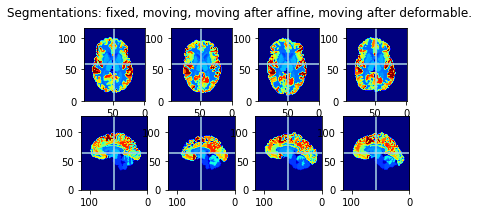

In [42]:
S_aff = my_transform_affine_and_warp(exp.S_mov, exp.grid, exp.A, exp.b, 
                                     mode='nearest')
S_def = my_transform_affine_and_warp(exp.S_mov, exp.grid, exp.A, exp.b, w_opt, 
                                     mode='nearest')
my_view_multi([exp.S_fix, exp.S_mov, S_aff, S_def], exp.hdr_fix, 
              cmap='jet', layout='A;S',
              title='Segmentations: fixed, moving, moving after affine, moving after deformable.')

### Measuring alignment between segmentations

Finally, to measure how well the registration aligned anatomical structures between the fixed and moving images, use the function `my_generalized_dice` to measure the [generalized Dice similarity coefficient](https://ieeexplore.ieee.org/abstract/document/1717643) between the segmentations. GDSC is a measure between 0 and 1 with 0 indicating no overlap and 1 indicating perfect overlap. The code below computes GDSC at different stages of the registration.

In [43]:
print('Alignment between segmentations images %s and %s' % (exp.fixed_id, exp.moving_id))
print('  GDSC before registration: ', my_generalized_dice(exp.S_fix, exp.S_mov))
print('  GDSC after affine registration', my_generalized_dice(exp.S_fix, S_aff))
print('  GDSC after deformable registration', my_generalized_dice(exp.S_fix, S_def))

Alignment between segmentations images 1002 and 1014
  GDSC before registration:  tensor(0.1664, device='cuda:0')
  GDSC after affine registration tensor(0.3797, device='cuda:0')
  GDSC after deformable registration tensor(0.4727, device='cuda:0')


### Evaluate GDSC for 10 subject pairs

In [54]:
def evaluate_gdsc(id_fix, id_mov, grad_msd=False, demons=False):
    """_summary_

    :param id_fix: ID of the fixed image
    :param id_mov: ID of the moving image
    :param grad_msd: whether to do grad_msd deformable registration, defaults to False
    :param demons: whether to do demons deformable registration, defaults to False
    
    :returns:
        Tuple (gdsc_all, segmentations) where

        - `gdsc_all` is the list of GDSC for none, affine, deformable registration
        - `segmentations` is the list of affine and deformable registered segmentations
    """    
    
    gdsc_all = []
    segmentations = []
    
    exp = RegistrationExperiment(str(id_fix),str(id_mov), data_path, 
                                 dtype=torch.float32, device=cuda)
    
    gdsc_no_reg = my_generalized_dice(exp.S_fix, exp.S_mov).cpu().numpy()
    gdsc_all.append(gdsc_no_reg)
    
    print('  GDSC before registration: ', gdsc_no_reg)
    
    # get affine registered image
    I_aff = my_transform_affine_and_warp(exp.I_mov, exp.grid, exp.A, exp.b)
    S_aff = my_transform_affine_and_warp(exp.S_mov, exp.grid, exp.A, exp.b, 
                                         mode='nearest')
    gdsc_affine = my_generalized_dice(exp.S_fix, S_aff).cpu().numpy()
    
    segmentations.append(S_aff)
    gdsc_all.append(gdsc_affine)
    
    print('  GDSC after affine registration', gdsc_affine)
    
    if grad_msd:
        # grad msd deformable registration
        _, _, w_gradmsd, _ = my_log_demons_multires(exp.I_fix, I_aff, [80,80,40], 
                                                    of_method='grad_msd', 
                                                    sigma=1.0, silent=True)
        S_gradmsd = my_transform_affine_and_warp(exp.S_mov, exp.grid, exp.A, 
                                                 exp.b, w_gradmsd, mode='nearest')
        gdsc_def_gradmsd = my_generalized_dice(exp.S_fix, S_gradmsd).cpu().numpy()
        segmentations.append(S_gradmsd)
        gdsc_all.append(gdsc_def_gradmsd)
        
        print('  GDSC after grad_msd deformable registration', gdsc_def_gradmsd)
    
    if demons:
        # demons deformable registration
        _, _, w_demons, _ = my_log_demons_multires(exp.I_fix, I_aff, [80,80,40],
                                                   of_method='demons', 
                                                   sigma=1.0, silent=True)
        S_demons = my_transform_affine_and_warp(exp.S_mov, exp.grid, exp.A, 
                                                exp.b, w_demons, mode='nearest')
        gdsc_def_demons = my_generalized_dice(exp.S_fix, S_demons).cpu().numpy()
        segmentations.append(S_demons)
        gdsc_all.append(gdsc_def_demons)
        
        print('  GDSC after demons deformable registration', gdsc_def_demons)
        
    return gdsc_all, segmentations

In [55]:
def print_mean_std(my_list):
    my_array = np.array(my_list)
    mean = np.mean(my_array)
    std = np.std(my_array)
    
    return mean, std

**TASK 6 (10 points): Pick 10 random pairs of fixed/moving subjects, perform registration, and record GDSC before registration, after affine registration, after deformable registration using Demons method, and after deformable registration using one of the other optical flow methods you implemented. Report summary statistics and conclude which technique performed best**.

In [56]:
list_atlas = [1000, 1001, 1002, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 
              1014, 1015, 1017, 1036]

gdsc_no_reg = []
gdsc_affine = []
gdsc_gradmsd = []
gdsc_demons = []

for i in range(10):
    # pick two IDs randomly from list above 
    id_fix, id_mov = np.random.choice(list_atlas, 2, replace=False)
    print(id_fix, id_mov)
    
    gdsc_all, _ = evaluate_gdsc(id_fix, id_mov, grad_msd=True, demons=True)
    
    gdsc_no_reg.append(gdsc_all[0])
    gdsc_affine.append(gdsc_all[1])
    gdsc_gradmsd.append(gdsc_all[2])
    gdsc_demons.append(gdsc_all[3])

1010 1009
  GDSC before registration:  0.34810483
  GDSC after affine registration 0.38572416
  GDSC after grad_msd deformable registration 0.52904797
  GDSC after demons deformable registration 0.48037314
1036 1008
  GDSC before registration:  0.1542009
  GDSC after affine registration 0.40421835
  GDSC after grad_msd deformable registration 0.52227885
  GDSC after demons deformable registration 0.49081564
1007 1036
  GDSC before registration:  0.13840845
  GDSC after affine registration 0.37898883
  GDSC after grad_msd deformable registration 0.4794024
  GDSC after demons deformable registration 0.41098288
1014 1001
  GDSC before registration:  0.29346314
  GDSC after affine registration 0.3662285
  GDSC after grad_msd deformable registration 0.486362
  GDSC after demons deformable registration 0.422521
1007 1014
  GDSC before registration:  0.3704944
  GDSC after affine registration 0.35586303
  GDSC after grad_msd deformable registration 0.46148005
  GDSC after demons deformable re

In [57]:
print('GDSC before registration: ', print_mean_std(gdsc_no_reg))
print('GDSC after affine registration', print_mean_std(gdsc_affine))
print('GDSC after grad_msd deformable registration', print_mean_std(gdsc_gradmsd))
print('GDSC after demons deformable registration', print_mean_std(gdsc_demons))

GDSC before registration:  (0.23462632, 0.096406795)
GDSC after affine registration (0.37313923, 0.020347958)
GDSC after grad_msd deformable registration (0.48655033, 0.021153117)
GDSC after demons deformable registration (0.43887815, 0.027367659)


| Method                                              | Dice Coefficient (Mean $\pm$ SD) |
|-----------------------------------------------------|----------------------------------|
| No registration                                     |                                  |
| Affine only                                         |                                  |
| Affine + deformable (grad_msd)                      |                                  |
| Affine + deformable (Demons)                        |

# Extension: Multi-Atlas Segmentation

In [58]:
list_atlas = [1000, 1001, 1002, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 
              1014, 1015, 1017, 1036]

atlas_imgs = np.random.choice(list_atlas, 10)
target_imgs = [1003, 1004, 1005, 1018, 1019]


In [64]:
id_fix = 1005

gdsc_affine = []
gdsc_def = []

weak_segmentations_aff = []
weak_segmentations_def = []

for id_mov in atlas_imgs:
    print(id_fix, id_mov)
    gdsc_all, segmentations = evaluate_gdsc(id_fix, id_mov, grad_msd=True)
    
    gdsc_affine.append(gdsc_all[1])
    gdsc_def.append(gdsc_all[2])
    
    weak_segmentations_aff.append(segmentations[0])
    weak_segmentations_def.append(segmentations[1])

1005 1001
  GDSC before registration:  0.28162566
  GDSC after affine registration 0.36923528
  GDSC after grad_msd deformable registration 0.46596432
1005 1001
  GDSC before registration:  0.28162566
  GDSC after affine registration 0.36923528
  GDSC after grad_msd deformable registration 0.46596432
1005 1001
  GDSC before registration:  0.28162566
  GDSC after affine registration 0.36923528
  GDSC after grad_msd deformable registration 0.46596432
1005 1010
  GDSC before registration:  0.2392239
  GDSC after affine registration 0.3702228
  GDSC after grad_msd deformable registration 0.46441805
1005 1013
  GDSC before registration:  0.29313156
  GDSC after affine registration 0.3711012
  GDSC after grad_msd deformable registration 0.49611044
1005 1010
  GDSC before registration:  0.2392239
  GDSC after affine registration 0.3702228
  GDSC after grad_msd deformable registration 0.46441805
1005 1009
  GDSC before registration:  0.2820854
  GDSC after affine registration 0.34989637
  GDSC

In [65]:
strong_segmentation_affine = my_majority_vote(weak_segmentations_aff)
strong_segmentation_def = my_majority_vote(weak_segmentations_def)

tensor(0.3697, device='cuda:0')
tensor(0.3981, device='cuda:0')


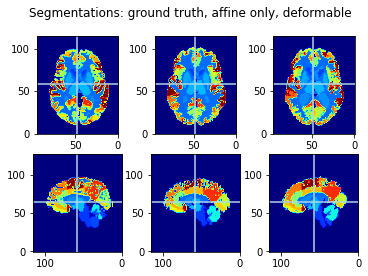

In [66]:
exp = RegistrationExperiment('1004','1005', data_path, dtype=torch.float32, device=cuda)

my_view_multi([exp.S_fix, strong_segmentation_affine, strong_segmentation_def], exp.hdr_fix, 
              cmap='jet', layout='A;S',
              title='Segmentations: ground truth, affine only, deformable')

print(my_generalized_dice(exp.S_fix, strong_segmentation_affine))
# print(my_generalized_dice(exp.S_fix, weak_segmentations_aff[0]))
# print(gdsc_affine[0])
print(my_generalized_dice(exp.S_fix, strong_segmentation_def))
# print(my_generalized_dice(exp.S_fix, weak_segmentations_def[0]))
# print(gdsc_def[0])

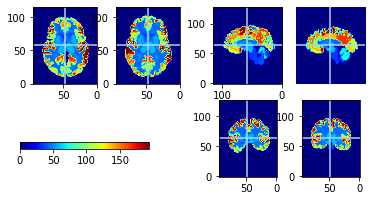

In [67]:
my_view_multi([exp.S_fix, strong_segmentation_affine], header=exp.hdr_fix, cmap='jet')

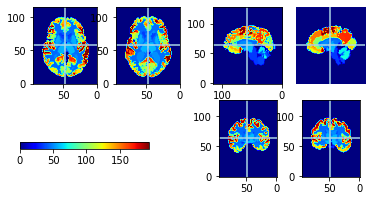

In [68]:
my_view_multi([exp.S_fix, strong_segmentation_def], header=exp.hdr_fix, cmap='jet')